In [1]:
# utils.py

from numpy.random import uniform
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as LA

from sklearn.preprocessing import StandardScaler


def create_one_hot_label(Y,N_C):
	''''
	Input
	Y: list of class labels (int)
	N_C: Number of Classes

	Returns
	List of one hot arrays with dimension N_C

	'''

	y_one_hot = []
	for y in Y:

		one_hot_label = np.zeros(N_C)

		one_hot_label[y] = 1.0
		y_one_hot.append(one_hot_label)

	return  y_one_hot


def subtract_mean_from_data(X,Y):
	''''
	Input
	X: List of data points
	Y: list of one hot class labels

	Returns
	X and Y with mean subtracted

	'''

	ss_x = StandardScaler(with_std = False)
	ss_y = StandardScaler(with_std = False)

	ss_x.fit(X)
	X = ss_x.transform(X)

	ss_y.fit(Y)
	Y = ss_y.transform(Y)

	return X,Y


def compute_covariance_matrix(X,Y):
	''''
	Input
	X: List of data points
	Y: list of one hot class labels

	Returns
	Covariance Matrix of X and Y
	Note: Assumes Mean is subtracted

	'''

	dim_x = np.max(X[0].shape)
	dim_y = np.max(Y[0].shape)

	N = len(X)
	C_XY = np.zeros([dim_x,dim_y])


	for i in range(N):
		x = np.array([X[i]])
		y = np.array([Y[i]])
		C_XY += np.dot(x.T,y)

	return C_XY/float(N)


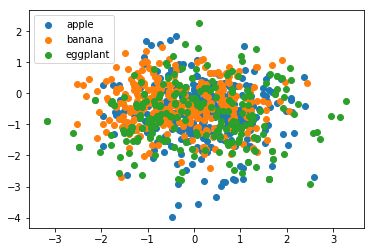

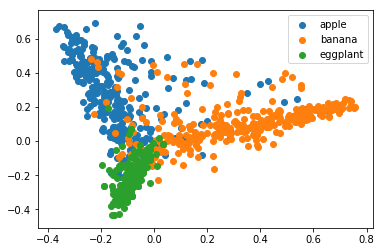

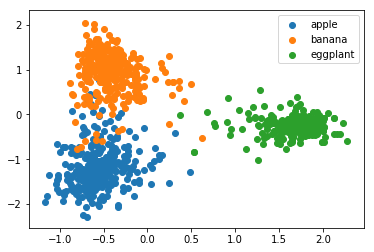

In [2]:
# projection.py

from numpy.random import uniform
from numpy.random import randn
import random
import time

import matplotlib.pyplot as plt

from scipy.linalg import eig
from scipy.linalg import sqrtm
from numpy.linalg import inv
from numpy.linalg import svd

from utils import create_one_hot_label
from utils import subtract_mean_from_data
from utils import compute_covariance_matrix

import numpy as np
import numpy.linalg as LA

import sys
from numpy.linalg import svd


class Project2D(): 

	'''
	Class to draw projection on 2D scatter space
	'''

	def __init__(self,projection, clss_labels):

		self.proj = projection
		self.clss_labels = clss_labels


	def project_data(self,X,Y,white=None): 

		'''
		Takes list of state space and class labels
		State space should be 2D
		Labels shoud be int
		'''

		p_a = []
		p_b = []
		p_c = []

		# Project all Data
		proj = np.matmul(self.proj,white)
	
		X_P = np.matmul(proj,np.array(X).T)
		
		for i in range(len(Y)):

			if Y[i] == 0: 
				p_a.append(X_P[:,i])
			elif Y[i] == 1: 
				p_b.append(X_P[:,i])
			else:
				p_c.append(X_P[:,i])

		
		p_a = np.array(p_a)
		p_b = np.array(p_b)
		p_c = np.array(p_c)

		plt.scatter(p_a[:,0],p_a[:,1],label = 'apple')
		plt.scatter(p_b[:,0],p_b[:,1],label = 'banana')
		plt.scatter(p_c[:,0],p_c[:,1],label = 'eggplant')

		plt.legend()

		plt.show()


class Projections():

	def __init__(self,dim_x,classes):

		'''
		dim_x: the dimension of the state space x 
		classes: The list of class labels 
		'''

		self.d_x = dim_x
		self.NUM_CLASSES = len(classes)
		


	def get_random_proj(self):
		'''
		Return A which is size 2 by 729
		'''
		A = np.zeros( (2, 729), "float" )
		for i in range(A.shape[0]):
			for j in range(A.shape[1]):
				A[i, j] = random.gauss(0, 1)
		return A


	def pca_projection(self,X,Y):

		'''
		Return U_2^T
		'''
		X_demeaned, _ = subtract_mean_from_data(X, X)
		Sigma_XX = compute_covariance_matrix(X_demeaned, X_demeaned)
		U, L, V = svd(Sigma_XX)
		U2 = U[:, [0, 1]]
		return U2.T


	def cca_projection(self,X,Y,k=2):

		'''
		Return U_K^T, \Simgma_{XX}^{-1/2}
		'''
		
		###SCALE AN IDENTITY MATRIX BY THIS TERM AND ADD TO COMPUTED COVARIANCE MATRIX TO PREVENT IT BEING SINGULAR ###
		reg = 1e-5

		y_one_hot = create_one_hot_label(Y, self.NUM_CLASSES)
		X, y_one_hot = subtract_mean_from_data(X, y_one_hot)
		Sigma_XX = compute_covariance_matrix(X, X)
		Sigma_XX += reg * np.eye(Sigma_XX.shape[0])
		Sigma_XY = compute_covariance_matrix(X, y_one_hot)
		Sigma_YY = compute_covariance_matrix(y_one_hot, y_one_hot)
		Sigma_YY += reg * np.eye(Sigma_YY.shape[0])
		Sigma_XX_inv_sqrt = inv(sqrtm(Sigma_XX))
		triple_Sigma = Sigma_XX_inv_sqrt.dot(Sigma_XY).dot( inv(sqrtm(Sigma_YY)) )
		U, L, V = svd(triple_Sigma)
		Uk = U[:, list(range( min(k, U.shape[1]) ))]
		return Uk.T, Sigma_XX_inv_sqrt


	def project(self,proj,white,X):
		'''
		proj, numpy matrix to perform projection
		whit, numpy matrix to perform whitenting
		X, list of states
		'''

		proj = np.matmul(proj,white)
	
		X_P = np.matmul(proj,np.array(X).T)

		return list(X_P.T)


if __name__ == "__main__":

	X = list(np.load('little_x_train.npy'))
	Y = list(np.load('little_y_train.npy'))

	CLASS_LABELS = ['apple','banana','eggplant']

	feat_dim = max(X[0].shape)
	projections = Projections(feat_dim,CLASS_LABELS)

	rand_proj = projections.get_random_proj()
	# Show Random 2D Projection
	proj2D_viz = Project2D(rand_proj,CLASS_LABELS)
	proj2D_viz.project_data(X,Y, white = np.eye(feat_dim))

	#PCA Projection 
	pca_proj = projections.pca_projection(X,Y)
	#Show PCA 2D Projection
	proj2D_viz = Project2D(pca_proj,CLASS_LABELS)
	proj2D_viz.project_data(X,Y, white = np.eye(feat_dim))

	#CCA Projection 
	cca_proj,white_cov = projections.cca_projection(X,Y)
	#Show CCA 2D Projection
	proj2D_viz = Project2D(cca_proj,CLASS_LABELS)
	proj2D_viz.project_data(X,Y,white = white_cov)


In [3]:
# Ridge_Model

from numpy.random import uniform
import random
import time

import numpy as np
import numpy.linalg as LA

import sys

from sklearn.linear_model import Ridge

from utils import create_one_hot_label


class Ridge_Model(): 

	def __init__(self,class_labels):

		###RIDGE HYPERPARAMETER
		self.lmda = 1.0
		self.class_labels = class_labels
		self.ridge_model = Ridge(self.lmda)


	def train_model(self,X,Y): 
		''''
		FILL IN CODE TO TRAIN MODEL
		MAKE SURE TO ADD HYPERPARAMTER TO MODEL 

		'''
		
		X = np.array(X)
		y_one_hot = create_one_hot_label(Y, len(self.class_labels))
		self.ridge_model.fit(X, y_one_hot)		
		

	def eval(self,x):
		''''
		Fill in code to evaluate model and return a prediction
		Prediction should be an integer specifying a class
		'''
		x = x.reshape(1, -1)
		y = self.ridge_model.predict(x)
		return np.argmax(y)
	

In [4]:
# LDA

import random
import time

import glob
import os
import pickle
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as LA

import sys
from numpy.linalg import inv
from numpy.linalg import det
from sklearn.svm import LinearSVC
from projection import Project2D, Projections

from utils import subtract_mean_from_data
from utils import compute_covariance_matrix


class LDA_Model(): 

	def __init__(self,class_labels):

		###SCALE AN IDENTITY MATRIX BY THIS TERM AND ADD TO COMPUTED COVARIANCE MATRIX TO PREVENT IT BEING SINGULAR ###
		self.reg_cov = 0.001
		self.NUM_CLASSES = len(class_labels)


	def train_model(self,X,Y): 
		''''
		FILL IN CODE TO TRAIN MODEL
		MAKE SURE TO ADD HYPERPARAMTER TO MODEL 

		'''
		ps = [ [] for j in range(self.NUM_CLASSES) ] 
		for i, y in enumerate(Y):
			ps[y].append(X[i])

		self.mean_list = []
		for lst in ps:
			self.mean_list.append( np.mean(np.array(lst), axis=0) )

		Sigma_XX = compute_covariance_matrix(X, X)
		Sigma_XX += self.reg_cov * np.identity(Sigma_XX.shape[0])
		self.Sigma_inv = inv(Sigma_XX)	
		

	def eval(self,x):
		''''
		Fill in code to evaluate model and return a prediction
		Prediction should be an integer specifying a class
		'''
		x = x.reshape(1, -1)
		y = {}
		for i in range(self.NUM_CLASSES):
			x_demeaned = x - self.mean_list[i]
			f = - x_demeaned.dot(self.Sigma_inv).dot(x_demeaned.T)
			y[i] = f.flatten()[0]
		return max(y, key=lambda x: y[x])
	

In [6]:
# QDA

import random
import time

import numpy as np
import numpy.linalg as LA

from numpy.linalg import inv
from numpy.linalg import det

from projection import Project2D, Projections

from utils import subtract_mean_from_data
from utils import compute_covariance_matrix


class QDA_Model(): 

	def __init__(self,class_labels):

		###SCALE AN IDENTITY MATRIX BY THIS TERM AND ADD TO COMPUTED COVARIANCE MATRIX TO PREVENT IT BEING SINGULAR ###
		self.reg_cov = 0.01
		self.NUM_CLASSES = len(class_labels)


	def train_model(self,X,Y): 
		''''
		FILL IN CODE TO TRAIN MODEL
		MAKE SURE TO ADD HYPERPARAMTER TO MODEL 

		'''
		ps = [ [] for j in range(self.NUM_CLASSES) ] 
		for i, y in enumerate(Y):
			ps[y].append(X[i])

		self.mean_list = []
		self.Sigma_inv_list = []
		for lst in ps:
			self.mean_list.append( np.mean(np.array(lst), axis=0) )
			Sigma_XX = compute_covariance_matrix(lst, lst)
			Sigma_XX += self.reg_cov * np.identity(Sigma_XX.shape[0])
			self.Sigma_inv_list.append(inv(Sigma_XX))	
		

	def eval(self,x):
		''''
		Fill in code to evaluate model and return a prediction
		Prediction should be an integer specifying a class
		'''
		x = x.reshape(1, -1)
		y = {}
		for i in range(self.NUM_CLASSES):
			x_demeaned = x - self.mean_list[i]
			f = - x_demeaned.dot(self.Sigma_inv_list[i]).dot(x_demeaned.T)
			y[i] = f.flatten()[0]
		return max(y, key=lambda x: y[x])


In [5]:
# SVM

from numpy.random import uniform
import random
import time

import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as LA

import sys

from sklearn.svm import LinearSVC
from projection import Project2D, Projections

from utils import create_one_hot_label


class SVM_Model(): 

	def __init__(self,class_labels,projection=None):

		###SLACK HYPERPARAMETER
		self.C = 1.0
		self.class_labels = class_labels
		self.svc_model = LinearSVC(C=self.C)


	def train_model(self,X,Y): 
		''''
		FILL IN CODE TO TRAIN MODEL
		MAKE SURE TO ADD HYPERPARAMTER TO MODEL 

		'''
		X = np.array(X)
		self.svc_model.fit(X, Y)
		

	def eval(self,x):
		''''
		Fill in code to evaluate model and return a prediction
		Prediction should be an integer specifying a class
		'''
		x = x.reshape(1, -1)
		y = self.svc_model.predict(x)
		return y[0]


In [17]:
# confusion_mat.py

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import IPython

def main():
    """
    Result
    Plot RANDOM confusion matrix (true labels vs. predicted labels)
    """
    true_labels = [random.randint(1, 10) for i in range(100)]
    predicted_labels = [random.randint(1, 10) for i in range(100)]

    # Plot confusion matrix (true labels vs. predicted labels)
    plot = getConfusionMatrixPlot(true_labels, predicted_labels)
    plot.show()


def getConfusionMatrix(true_labels, predicted_labels):
    """
    Input
    true_labels: actual labels
    predicted_labels: model's predicted labels

    Output
    cm: confusion matrix (true labels vs. predicted labels)
    """

    # Generate confusion matrix using sklearn.metrics
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm


def plotConfusionMatrix(cm, alphabet):
    """
    Input
    cm: confusion matrix (true labels vs. predicted labels)
    alphabet: names of class labels

    Output
    Plot confusion matrix (true labels vs. predicted labels)
    """

    fig = plt.figure()
    plt.clf()                       # Clear plot
    ax = fig.add_subplot(111)       # Add 1x1 grid, first subplot
    ax.set_aspect(1)
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=80)

    plt.colorbar(res)               # Add color bar

    width = len(cm)                 # Width of confusion matrix
    height = len(cm[0])             # Height of confusion matrix

    # Annotate confusion entry with numeric value
    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))


    # Plot confusion matrix (true labels vs. predicted labels)
    plt.xticks(range(width), alphabet[:width], rotation=90)
    plt.yticks(range(height), alphabet[:height])
    plt.show()
    return plt


def getConfusionMatrixPlot(true_labels, predicted_labels, alphabet):
    """
    Input
    true_labels: actual labels
    predicted_labels: model's predicted labels
    alphabet: names of class labels

    Output
    Plot confusion matrix (true labels vs. predicted labels)
    """

    # Generate confusion matrix using sklearn.metrics
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    # Plot confusion matrix (true labels vs. predicted labels)
    return plotConfusionMatrix(cm, alphabet)


def getFontColor(value):
    """
    Input
    value: confusion entry value

    Output
    font color for confusion entry
    """
    if value < -1:
        return "black"
    else:
        return "white"


if __name__ == "__main__":
    main()


[[310  15   0]
 [ 10 298   1]
 [  2   0 240]]


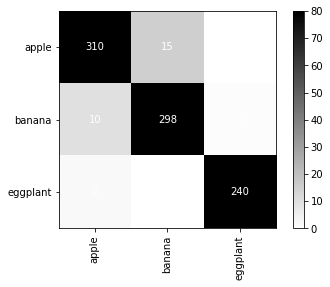

[[83 17  3]
 [ 6 98  4]
 [ 9  8 76]]


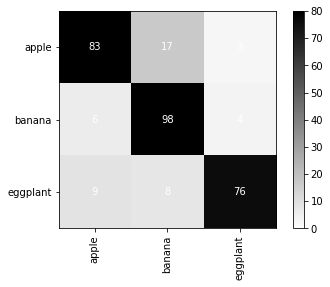

[[310  15   0]
 [ 10 298   1]
 [  2   1 239]]


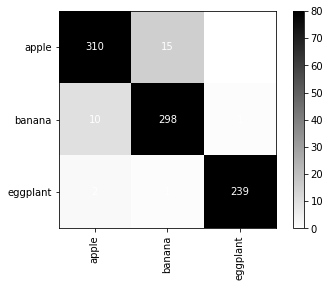

[[83 17  3]
 [ 6 99  3]
 [ 9  9 75]]


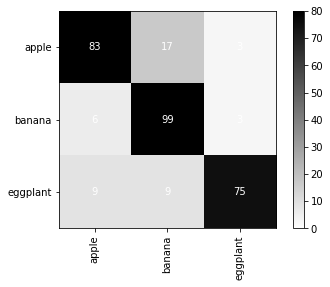

[[307  11   7]
 [ 20 278  11]
 [  0   2 240]]


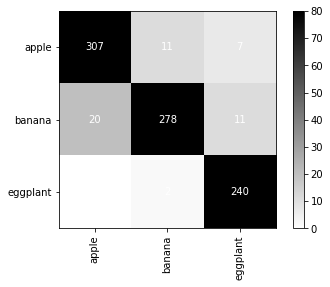

[[77 19  7]
 [12 85 11]
 [ 9 11 73]]


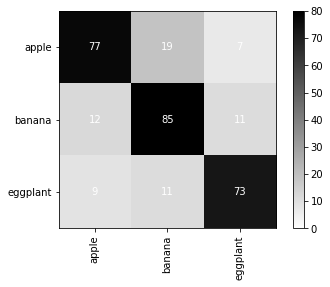

[[311  14   0]
 [ 10 298   1]
 [  2   1 239]]


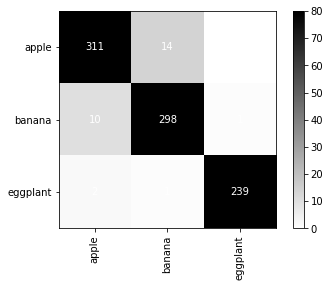

[[83 17  3]
 [ 7 97  4]
 [ 7  9 77]]


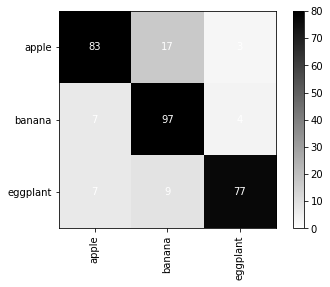

In [7]:
# linear_classification.py

from numpy.random import uniform
import random
import time

import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as LA

import sys

from projection import Project2D, Projections
from confusion_mat import getConfusionMatrixPlot

from ridge_model import Ridge_Model
from qda_model import QDA_Model
from lda_model import LDA_Model
from svm_model import SVM_Model


CLASS_LABELS = ['apple','banana','eggplant']


class Model():
	""" Generic wrapper for specific model instance. """

	def __init__(self, model):
		""" Store specific pre-initialized model instance. """

		self.model = model


	def train_model(self,X,Y): 
		""" Train using specific model's training function. """
		
		self.model.train_model(X,Y)
	

	def test_model(self,X,Y):
		""" Test using specific model's eval function. """
		
		labels = []						# List of actual labels
		p_labels = []					# List of model's predictions
		success = 0						# Number of correct predictions
		total_count = 0					# Number of images

		for i in range(len(X)):
			
			x = X[i]					# Test input
			y = Y[i]					# Actual label
			y_ = self.model.eval(x)		# Model's prediction
			labels.append(y)
			p_labels.append(y_)

			if y == y_:
				success += 1
			total_count +=1 
			
		
		
		# Compute Confusion Matrix
		getConfusionMatrixPlot(labels,p_labels,CLASS_LABELS)


if __name__ == "__main__":

	# Load Training Data and Labels
	X = list(np.load('little_x_train.npy'))
	Y = list(np.load('little_y_train.npy'))

	# Load Validation Data and Labels
	X_val = list(np.load('little_x_val.npy'))
	Y_val = list(np.load('little_y_val.npy'))

	CLASS_LABELS = ['apple','banana','eggplant']


	# Project Data to 200 Dimensions using CCA
	feat_dim = max(X[0].shape)
	projections = Projections(feat_dim,CLASS_LABELS)
	cca_proj,white_cov = projections.cca_projection(X,Y,k=2)

	X = projections.project(cca_proj,white_cov,X)
	X_val = projections.project(cca_proj,white_cov,X_val)


	####RUN RIDGE REGRESSION#####
	ridge_m = Ridge_Model(CLASS_LABELS)
	model = Model(ridge_m)

	model.train_model(X,Y)
	model.test_model(X,Y)
	model.test_model(X_val,Y_val)


	####RUN LDA REGRESSION#####

	lda_m = LDA_Model(CLASS_LABELS)
	model = Model(lda_m)

	model.train_model(X,Y)
	model.test_model(X,Y)
	model.test_model(X_val,Y_val)


	####RUN QDA REGRESSION#####

	qda_m = QDA_Model(CLASS_LABELS)
	model = Model(qda_m)

	model.train_model(X,Y)
	model.test_model(X,Y)
	model.test_model(X_val,Y_val)
	

	####RUN SVM REGRESSION#####

	svm_m = SVM_Model(CLASS_LABELS)
	model = Model(svm_m)

	model.train_model(X,Y)
	model.test_model(X,Y)
	model.test_model(X_val,Y_val)


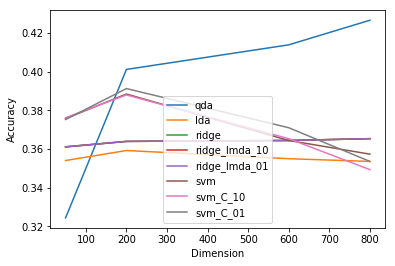

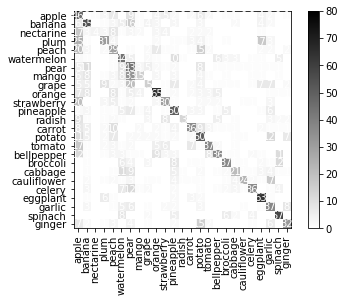

In [8]:
# hyper_search.py

import IPython
from numpy.random import uniform
import random
import time

import glob
import os
import pickle
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as LA

import sys


from projection import Project2D, Projections

from confusion_mat import getConfusionMatrix
from confusion_mat import plotConfusionMatrix

from ridge_model import Ridge_Model
from qda_model import QDA_Model
from lda_model import LDA_Model
from svm_model import SVM_Model


CLASS_LABELS = ['apple','banana','nectarine','plum','peach','watermelon','pear','mango','grape','orange','strawberry','pineapple', 
	'radish','carrot','potato','tomato','bellpepper','broccoli','cabbage','cauliflower','celery','eggplant','garlic','spinach','ginger']


def eval_model(X,Y,k,model_key,proj):
	# PROJECT DATA 
	cca_proj,white_cov = proj.cca_projection(X,Y,k=k)

	X_p = proj.project(cca_proj,white_cov,X)
	X_val_p = proj.project(cca_proj,white_cov,X_val)

	# TRAIN MODEL 
	model = models[model_key]

	model.train_model(X_p,Y)
	acc,cm = model.test_model(X_val_p,Y_val)

	return acc,cm


class Model(): 
	""" Generic wrapper for specific model instance. """


	def __init__(self,model):
		""" Store specific pre-initialized model instance. """

		self.model = model


	def train_model(self,X,Y): 
		""" Train using specific model's training function. """
		
		self.model.train_model(X,Y)


	def test_model(self,X,Y):
		""" Test using specific model's eval function. """

		labels = []						# List of actual labels
		p_labels = []					# List of model's predictions
		success = 0.0					# Number of correct predictions
		total_count = 0.0				# Number of images


		for i in range(len(X)):
			
			x = X[i]					# Test input
			y = Y[i]					# Actual label
			y_ = self.model.eval(x)		# Model's prediction
			labels.append(y)
			p_labels.append(y_)

			if y == y_:
				success += 1.0
			total_count +=1.0 
			
		
		return success/total_count, getConfusionMatrix(labels,p_labels)


if __name__ == "__main__":

	# Load Training Data and Labels
	X = list(np.load('big_x_train.npy'))
	Y = list(np.load('big_y_train.npy'))

	# Load Validation Data and Labels
	X_val = list(np.load('big_x_val.npy'))
	Y_val = list(np.load('big_y_val.npy'))


	# Project Data to 200 Dimensions using CCA
	feat_dim = max(X[0].shape)
	projections = Projections(feat_dim,CLASS_LABELS)
	


	models = {}						# Dictionary of key: model names, value: model instance

	#########MODELS TO EVALUATE############
	qda_m = QDA_Model(CLASS_LABELS)
	models['qda'] =  Model(qda_m)

	lda_m = LDA_Model(CLASS_LABELS)
	models['lda'] = Model(lda_m)

	ridge_m = Ridge_Model(CLASS_LABELS)
	models['ridge'] = Model(ridge_m)

	ridge_m_10 = Ridge_Model(CLASS_LABELS)
	ridge_m.lmda = 10.0
	models['ridge_lmda_10'] = Model(ridge_m_10)

	ridge_m_01 = Ridge_Model(CLASS_LABELS)
	ridge_m.lmda = 0.1
	models['ridge_lmda_01'] = Model(ridge_m_01)

	svm_m = SVM_Model(CLASS_LABELS)
	models['svm'] = Model(svm_m)

	svm_m_10 = SVM_Model(CLASS_LABELS)
	svm_m.C = 10.0
	models['svm_C_10'] = Model(svm_m_10)

	svm_m_01 = SVM_Model(CLASS_LABELS)
	svm_m.C = 0.1
	models['svm_C_01'] = Model(svm_m_01)


	#########GRID SEARCH OVER MODELS############
	highest_accuracy = 0			# Highest validation accuracy
	best_model_name = None			# Best model name
	best_model = None				# Best model instance

	K = [50,200,600,800]# List of dimensions


	for model_key in models.keys():
		val_acc = []				# List of model's accuracies for each dimension 
		for k in K:
			
			# Evaluate specific model's validation accuracy on specific dimension
			acc,c_m = eval_model(X,Y,k,model_key,projections)

			val_acc.append(acc)

			if acc > highest_accuracy: 
				highest_accuracy = acc
				best_model_name = model_key
				best_cm = c_m
				
		# Plot specific model's accuracies across validation error
		plt.plot(K,val_acc,label=model_key)


	# Display aggregate plot of models across validation error
	plt.legend()
	plt.xlabel('Dimension') 
	plt.ylabel('Accuracy') 
	plt.show()


	# Plot best model's confusion matrix
	plotConfusionMatrix(best_cm,CLASS_LABELS)
	